In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

In [10]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
### YOUR CODE HERE
from tensorflow.keras.layers import Dropout
from tensorflow.keras import regularizers
# Figure out how to import regularizers
###
import tensorflow.keras.utils as ku 
import numpy as np 

In [11]:
tokenizer = Tokenizer()
!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/sonnets.txt \
    -O /tmp/sonnets.txt
data = open('/tmp/sonnets.txt').read()

corpus = data.lower().split("\n")


tokenizer.fit_on_texts(corpus)
total_words = len(tokenizer.word_index) + 1

# create input sequences using list of tokens
input_sequences = []
for line in corpus:
	token_list = tokenizer.texts_to_sequences([line])[0]
	for i in range(1, len(token_list)):
		n_gram_sequence = token_list[:i+1]
		input_sequences.append(n_gram_sequence)


# pad sequences 
max_sequence_len = max([len(x) for x in input_sequences])
input_sequences = np.array(pad_sequences(input_sequences, maxlen=max_sequence_len, padding='pre'))

# create predictors and label
predictors, label = input_sequences[:,:-1],input_sequences[:,-1]

label = ku.to_categorical(label, num_classes=total_words)

--2021-03-30 05:00:33--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/sonnets.txt
Resolving storage.googleapis.com (storage.googleapis.com)... 172.253.115.128, 172.217.2.112, 172.253.63.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.253.115.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 93578 (91K) [text/plain]
Saving to: ‘/tmp/sonnets.txt’

/tmp/sonnets.txt    100%[===================>]  91.38K  --.-KB/s    in 0.001s  

2021-03-30 05:00:33 (117 MB/s) - ‘/tmp/sonnets.txt’ saved [93578/93578]



In [14]:
print(total_words)
predictors.shape

3211


(15462, 10)

In [21]:
model = Sequential()
model.add(Embedding(input_dim=total_words, output_dim=64, input_length=max_sequence_len-1))
model.add(Bidirectional(LSTM(100,return_sequences=True)))
model.add(Dropout(0.3))
model.add(LSTM(100,return_sequences=False))
model.add(Dense(total_words//3, activation='relu', kernel_regularizer=regularizers.l1_l2(l1=0.001, l2=0.001), bias_regularizer=regularizers.l1_l2(l1=0.001, l2=0.001)))
model.add(Dense(total_words, activation='softmax'))
# Pick an optimizer
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())


Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 10, 64)            205504    
_________________________________________________________________
bidirectional_1 (Bidirection (None, 10, 200)           132000    
_________________________________________________________________
dropout_4 (Dropout)          (None, 10, 200)           0         
_________________________________________________________________
lstm_9 (LSTM)                (None, 100)               120400    
_________________________________________________________________
dense_8 (Dense)              (None, 1070)              108070    
_________________________________________________________________
dense_9 (Dense)              (None, 3211)              3438981   
Total params: 4,004,955
Trainable params: 4,004,955
Non-trainable params: 0
____________________________________________

In [22]:
 history = model.fit(predictors, label, epochs=200, verbose=1)

Epoch 1/200
484/484 [==============================] - 9s 11ms/step - loss: 8.0048 - accuracy: 0.0175
Epoch 2/200
484/484 [==============================] - 5s 11ms/step - loss: 6.5134 - accuracy: 0.0247
Epoch 3/200
484/484 [==============================] - 5s 11ms/step - loss: 6.5040 - accuracy: 0.0220
Epoch 4/200
484/484 [==============================] - 5s 11ms/step - loss: 6.4371 - accuracy: 0.0271
Epoch 5/200
484/484 [==============================] - 5s 11ms/step - loss: 6.3926 - accuracy: 0.0290
Epoch 6/200
484/484 [==============================] - 5s 11ms/step - loss: 6.3272 - accuracy: 0.0342
Epoch 7/200
484/484 [==============================] - 5s 11ms/step - loss: 6.2248 - accuracy: 0.0378
Epoch 8/200
484/484 [==============================] - 5s 11ms/step - loss: 6.1583 - accuracy: 0.0376
Epoch 9/200
484/484 [==============================] - 5s 11ms/step - loss: 6.0664 - accuracy: 0.0437
Epoch 10/200
484/484 [==============================] - 5s 11ms/step - loss: 5.995

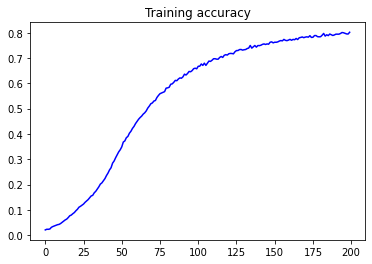

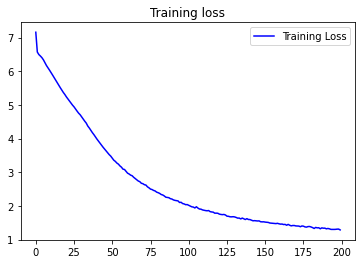

In [23]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
loss = history.history['loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training accuracy')
plt.title('Training accuracy')

plt.figure()

plt.plot(epochs, loss, 'b', label='Training Loss')
plt.title('Training loss')
plt.legend()

plt.show()

In [24]:
seed_text = "Help me Obi Wan Kenobi, you're my only hope"
next_words = 100
  
for _ in range(next_words):
	token_list = tokenizer.texts_to_sequences([seed_text])[0]
	token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
	predicted = model.predict_classes(token_list, verbose=0)
	output_word = ""
	for word, index in tokenizer.word_index.items():
		if index == predicted:
			output_word = word
			break
	seed_text += " " + output_word
print(seed_text)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Help me Obi Wan Kenobi, you're my only hope some good antique pen be lie be bettering so not so grace such woe grace write to praise to dwell in dross woe worth find it room twain swearing swearing young new bright say you convertest live thee to thine life ' for their ' have tell me now stay so foul foes dwells amazeth amazeth borne of show things woe woe ' be brought to store am would see twain survey behind a map of thy field clearer light owe worn spread spread eyed borne of make where behold she happy past such show thine wrong be cured live
